# Модель оттока клиентов «Бета-Банка»

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Имеются исторические данные о поведении клиентов и расторжении договоров с банком.

Цель проекта - построить модель с предельно большим значением F1-меры, дополнительно измеряя AUC-ROC и  сравнивая её значение с F1-мерой.


Данные хранятся в файле "Churn.csv". Данные содержат 10000 записей. Каждая строка в наборе данных — это информация об одном пользователе. Описание признаков:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента (Целевой признак)

План работы
1. Загрузить и подготовить данные.
2. Исследовать баланс классов, обучить модель без учёта дисбаланса.
3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.
4. Провести финальное тестирование.

In [1]:
# Импорт библиотек
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, f1_score, RocCurveDisplay
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

## Шаг 1. Загрузка и подготовка данных

In [3]:
df = pd.read_csv('f:/yandex-practicum/datasets/Churn.csv')

df.info() # просмотр размера таблицы, типов данных, количества non-null
display(df.head()) # просмотр первых строк данных
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


Данные содержат 10 000 строк, есть пропуски в поле Tenure

### 1.2 Подготовка данных
План подготовки данных

- Переименовать столбцы
- Проверить наличие явных дубликатов, при необходимости обработать дубликаты 
- Преобразовать типы данных при необходимости
- Обработать пропуски
- Поиск выбросов, при необходимости обработка



In [4]:
# Удаление столбца с номером строки
df.drop('RowNumber',axis=1,inplace=True) 

In [5]:
# Переименование названия столбцов в змеиный регистр
df.set_axis(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],axis = 'columns',inplace = True)

In [6]:
# Поиск явных дубликатов
print('Явных дубликатов', df.duplicated().sum())

Явных дубликатов 0


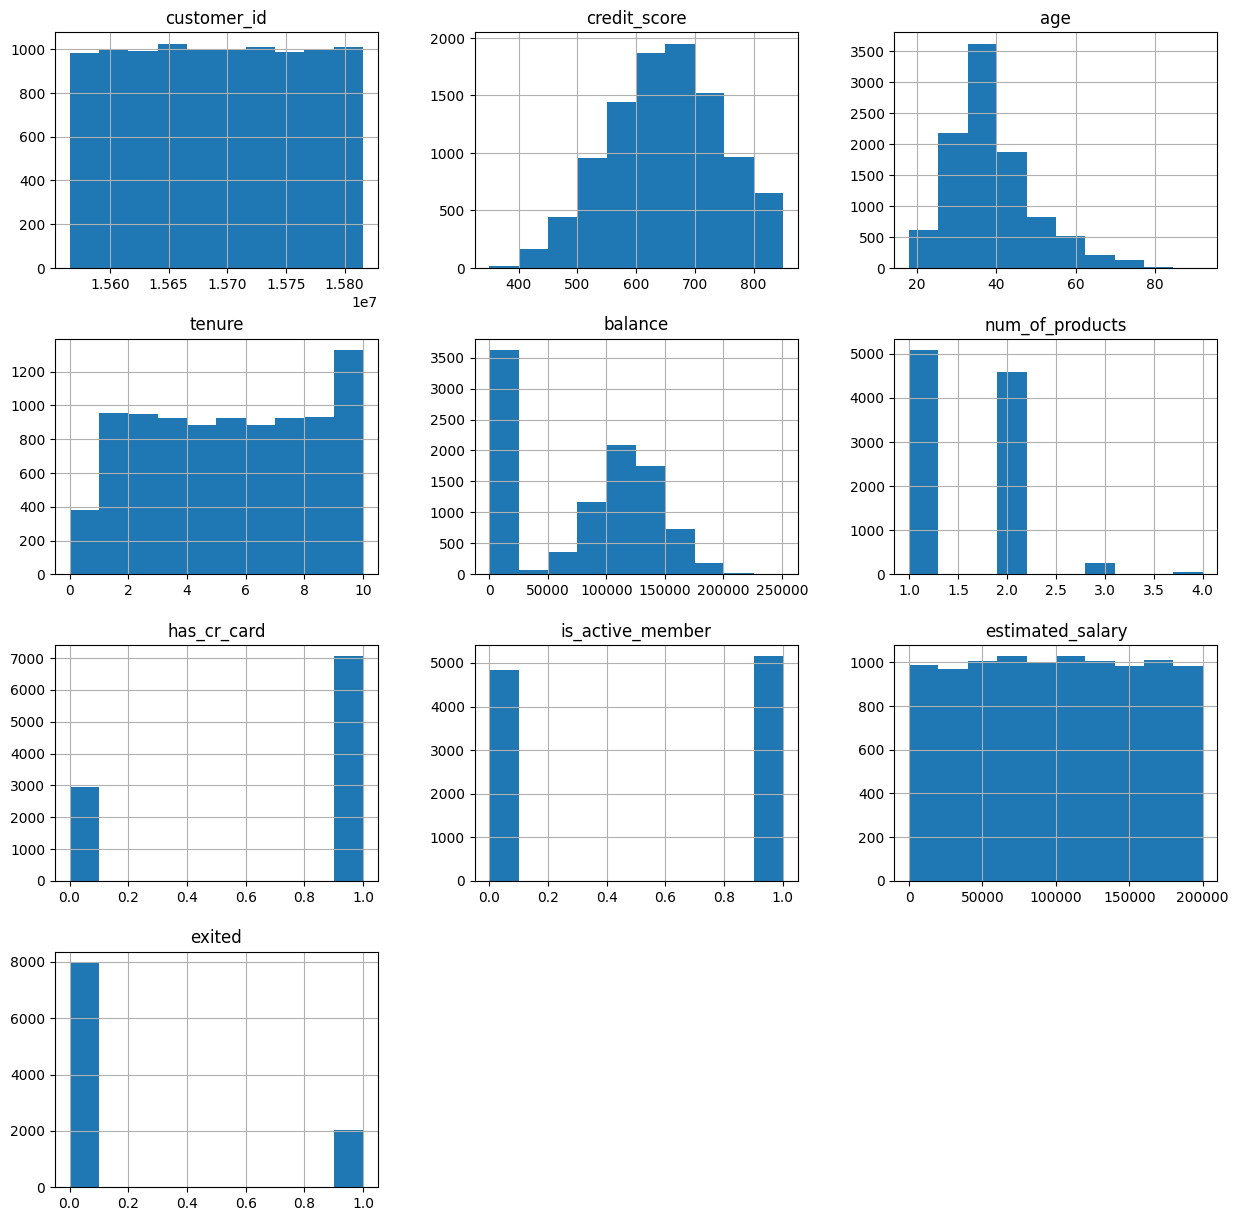

In [7]:
df.hist(figsize=(15,15));

#### 1.2.1. Обработка пропусков в длительности обслуживания
План обработки пропусков

1. Преобразовать типы данных при необходимости
2. Посмотреть уникальные значения длительностей обслуживания
3. Посмотреть строки с пропущенными значениями 
4. Сравнить describe для строк с пропусками и без пропусков
5. построить и проанализировать гистограммы для строк с пропусками и без пропусков
6. Посмотреть доли категориальных значений в этих выборках

В столбце tenure есть 909 пропусков

In [8]:
# Изменение типа данных столбца 'tenure'
df['tenure'] = df['tenure'].astype('Int32')
df['tenure'].unique()

<IntegerArray>
[2, 1, 8, 7, 4, 6, 3, 10, 5, 9, 0, <NA>]
Length: 12, dtype: Int32

In [9]:
df[df['tenure'].isna()].head()


,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,15589475,Azikiwe,591,Spain,Female,39,<NA>,0.00,3,1,0,"140,469.38",1
48,15766205,Yin,550,Germany,Male,38,<NA>,"103,391.38",1,0,1,"90,878.13",0
51,15768193,Trevisani,585,Germany,Male,36,<NA>,"146,050.97",2,0,0,"86,424.57",0
53,15702298,Parkhill,655,Germany,Male,41,<NA>,"125,561.97",1,0,0,"164,040.94",1
60,15651280,Hunter,742,Germany,Male,35,<NA>,"136,857.00",1,0,0,"84,509.57",0


In [10]:
display(df[df['tenure'].isna()].describe())
df[~df['tenure'].isna()].describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,909.00,909.00,909.00,0,909.00,909.00,909.00,909.00,909.00,909.00
mean,"15,689,814.58",648.45,38.65,<NA>,"76,117.34",1.53,0.71,0.51,"99,180.39",0.20
std,"75,112.25",99.08,9.79,<NA>,"63,105.69",0.59,0.45,0.50,"56,378.06",0.40
min,"15,565,806.00",359.00,18.00,<NA>,0.00,1.00,0.00,0.00,106.67,0.00
25%,"15,626,578.00",580.00,32.00,<NA>,0.00,1.00,0.00,0.00,"49,872.33",0.00
50%,"15,686,870.00",647.00,37.00,<NA>,"96,674.55",1.00,1.00,1.00,"99,444.02",0.00
75%,"15,756,804.00",718.00,43.00,<NA>,"128,554.98",2.00,1.00,1.00,"145,759.70",0.00
max,"15,815,690.00",850.00,92.00,<NA>,"206,663.75",4.00,1.00,1.00,"199,390.45",1.00


,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,"9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00"
mean,"15,691,053.16",650.74,38.95,5.00,"76,522.74",1.53,0.70,0.52,"100,181.21",0.20
std,"71,614.19",96.41,10.56,2.89,"62,329.53",0.58,0.46,0.50,"57,624.76",0.40
min,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"15,628,985.50",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,227.74",0.00
50%,"15,691,061.00",652.00,37.00,5.00,"97,318.25",1.00,1.00,1.00,"100,240.20",0.00
75%,"15,752,851.50",717.00,44.00,7.00,"127,561.89",2.00,1.00,1.00,"149,567.21",0.00
max,"15,815,660.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


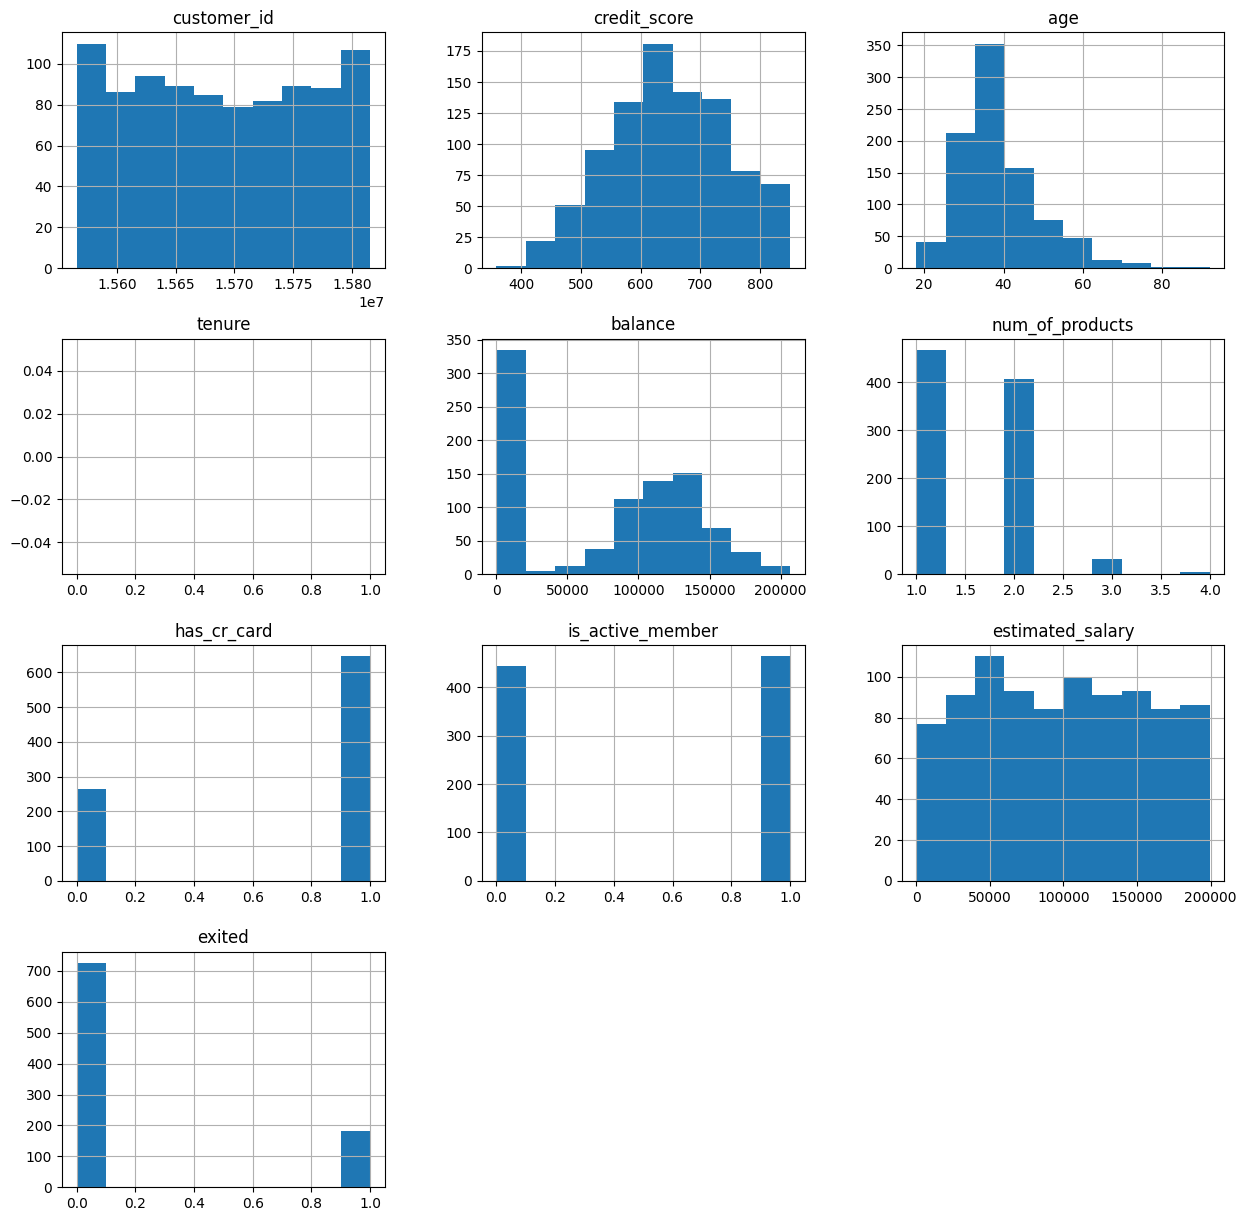

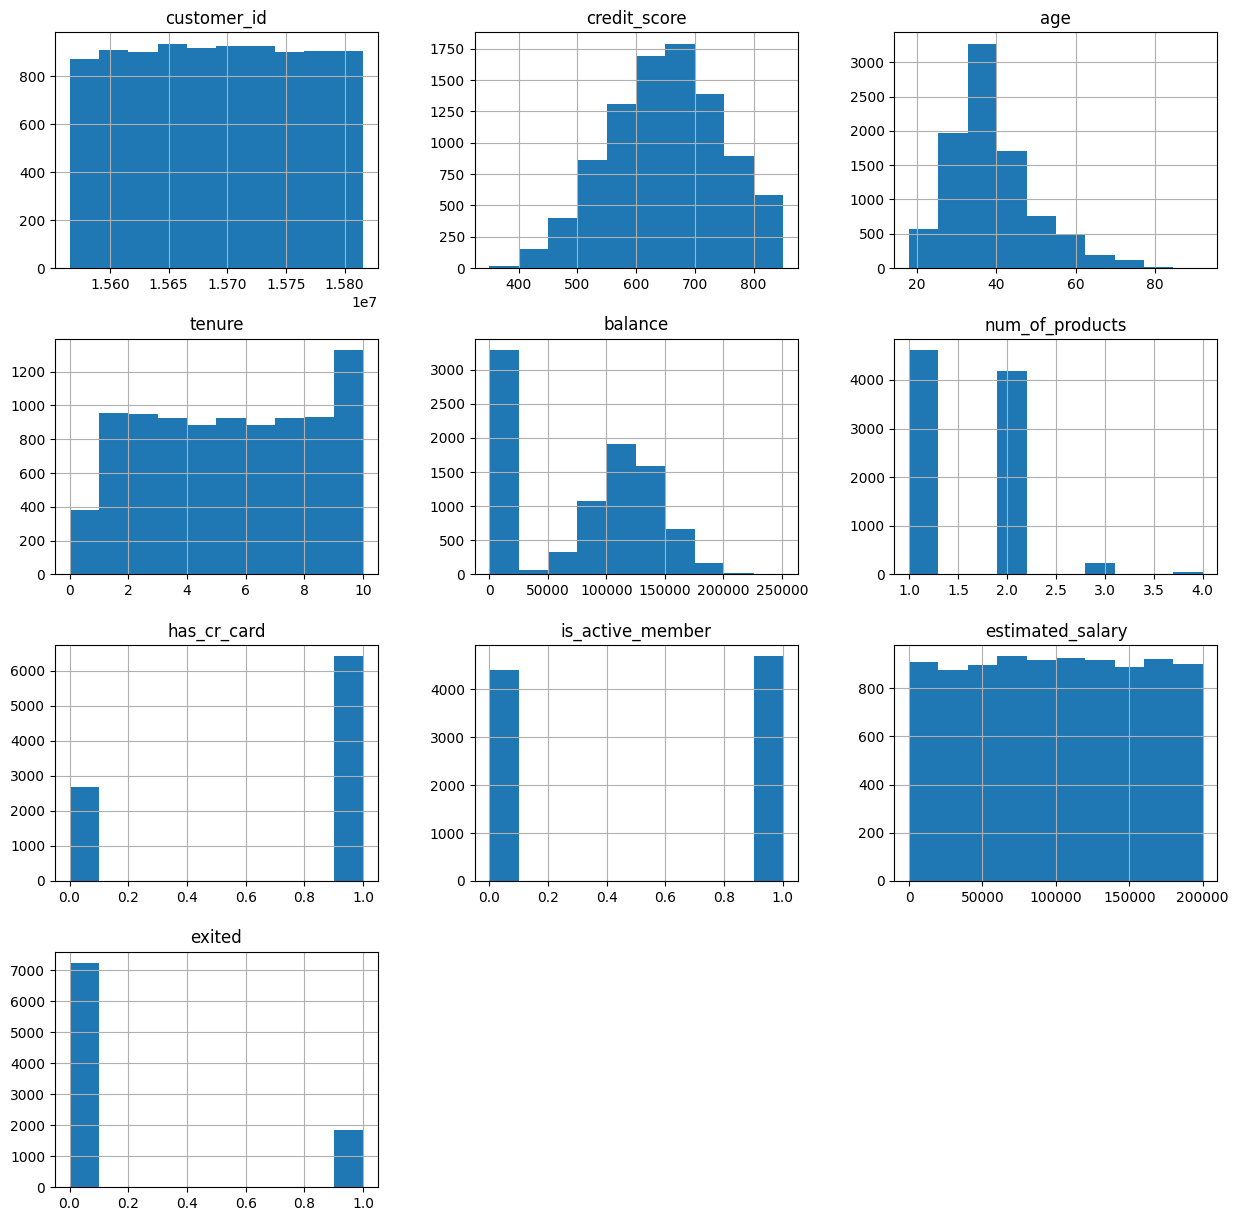

In [11]:
df[df['tenure'].isna()].hist(figsize=(15,15));
df[~df['tenure'].isna()].hist(figsize=(15,15));

In [12]:
display(df[~df['tenure'].isna()]['geography'].value_counts(normalize=True))
display(df[df['tenure'].isna()]['geography'].value_counts(normalize=True))
display(df[~df['tenure'].isna()]['gender'].value_counts(normalize=True))
display(df[df['tenure'].isna()]['gender'].value_counts(normalize=True))

France    0.50
Germany   0.25
Spain     0.25
Name: geography, dtype: float64

France    0.51
Spain     0.25
Germany   0.24
Name: geography, dtype: float64

Male     0.55
Female   0.45
Name: gender, dtype: float64

Male     0.53
Female   0.47
Name: gender, dtype: float64

In [13]:
df_with_na=df[df['tenure'].isna()].copy() # сохраняю выборку с пропусками
df['customer_id'].unique().shape #повторов нет

(10000,)

In [14]:
# удаление строк с пропусками
df_with_na.fillna(value=df['tenure'].median(),inplace=True)  
#df_with_na.fillna(value=0,inplace=True)
#df.fillna(value=df['tenure'].median(),inplace=True)
df = df.dropna() #inplace=True

customer_id        -0.01
credit_score       -0.02
age                 0.28
tenure             -0.02
balance             0.12
num_of_products    -0.05
has_cr_card        -0.01
is_active_member   -0.16
estimated_salary    0.02
exited              1.00
Name: exited, dtype: float64


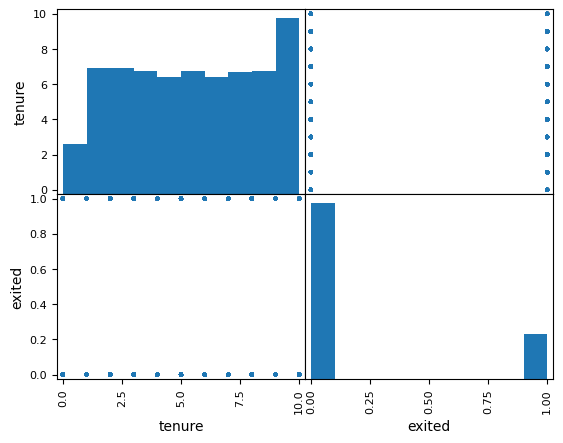

In [15]:
print(df.corr().loc['exited'])
pd.plotting.scatter_matrix(df[['tenure','exited']]);

#### 1.2.2. Подготовка признаков для модели
- удалить незначимые признаки ('customer_id','surname')
- выполнить кодирование категориальных признаков
- создать обучающую, валидационную и тестовую выборки
- выполнить масштабирование численных признаков




In [16]:
# Удаление незначимых признаков
df.drop(['customer_id','surname'] , axis=1, inplace=True)
#df.drop(['customer_id','surname','tenure','credit_score','num_of_products', 'has_cr_card','estimated_salary'] , axis=1, inplace=True) #,'tenure'

In [17]:
#Кодирование категориальных признаков методом OHE
df_ohe = pd.get_dummies(df,drop_first=True)
df_ohe.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

In [18]:
# создание обучающей, валидационной и тестовой выборки в пропорции 3:1:1
target = df_ohe['exited']
features = df_ohe.drop(['exited'] , axis=1)

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345)

In [19]:
print('Размеры выборок:', features_train.shape, features_valid.shape, features_test.shape)

Размеры выборок: (5454, 11) (1818, 11) (1819, 11)


In [20]:
# масштабирование численных признаков
numeric = ['credit_score', 'age', 'balance', 'num_of_products', 'estimated_salary', 'tenure'] # все численные
#numeric = ['age', 'balance'] # заметно коррелирующие
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])



## Вывод 
Данные загружены.

Выполнено переименование названий столбцов в змеиный регистр

Выполнен поиск явных дубликатов - явных дубликатов нет

Вывод по обработке пропусков в длительностях обслуживания (tenure)
1. Преобразован тип данных к целочисленному
2. в столбце имеются уникальные значения длительностей от 0 до 10 лет, а также 909 занчений NA 
3. В результате просмотра строк с пропущенными значениями возможные причины пропусков не выявлены, пропуски присутсвуют для записей различных клиентов из разных стран, разного пола и т.д.
4. В результате сравния describe для строк с пропусками и без пропусков установлено, что минимальные, средние, максимальные, std в этих выборках слабо отличаются. 
5. В результате анализа гистограмм для строк с пропусками и без пропусков, не выявлено значительных отличий в распределениях численных признаков.
6. Доли категориальных значений в этих выборках также примерно равны. 

В результате анализа выборок с пропусками и без пропусков в длительности обслуживания, делается предположение о том, что в выборке с пропусками такие же распределения признаков и целевого признака. В связи с этим удаление строк с пропусками не приведет к искажению распределений оставшейся выборки по сравнению с исходной. Произведено удаление строк с пропусками

В результате анализа гистограмм выявлено, что число клиентов по длительности обслуживания распределено равномерно, кроме нулевого года и 10 года, просадка в нулевом году может быть вызвана, например, выгрузкой базы в середене года. Выброс за 10 год может быть ошибкой.


Вывод по подготовке признаков
- удалены незначимые признаки ('customer_id','surname')
- закодированы категориальные признаки
- созданы обучающая, валидационная и тестовая выборки (3:1:1)
- выполнено масштабирование численных признаков

## Шаг 2. Обучение моделей, исследование баланса классов 
 
Исследовать баланс классов
Обучить модель без учёта дисбаланса

In [21]:
metrics = []
for i,j in zip([DecisionTreeClassifier,RandomForestClassifier,LogisticRegression],['Решающее дерево','Случайный лес','Логистическая регрессия']):
    model = i(random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('\n',j)
    print(f"Матрица ошибок:\n {confusion_matrix(target_valid,predicted_valid)}")
    metrics += [[j, accuracy_score(target_valid, predicted_valid), recall_score(target_valid,predicted_valid), 
       precision_score(target_valid,predicted_valid), f1_score(target_valid,predicted_valid),
       roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])]]
display(pd.DataFrame(metrics,columns =['Модель','Accuracy','Полнота','Точность','F1','AUC-ROC']))
display('Доли классов', target_train.value_counts(normalize=True))
print(f"Accuracy константной модели: {accuracy_score(target_valid, pd.Series(0,features_valid.index)):.2f}")



 Решающее дерево
Матрица ошибок:
 [[1260  192]
 [ 183  183]]

 Случайный лес
Матрица ошибок:
 [[1397   55]
 [ 206  160]]

 Логистическая регрессия
Матрица ошибок:
 [[1405   47]
 [ 293   73]]


,Модель,Accuracy,Полнота,Точность,F1,AUC-ROC
0,Решающее дерево,0.79,0.50,0.49,0.49,0.68
1,Случайный лес,0.86,0.44,0.74,0.55,0.83
2,Логистическая регрессия,0.81,0.20,0.61,0.30,0.77


'Доли классов'

0   0.79
1   0.21
Name: exited, dtype: float64

Accuracy константной модели: 0.80


### Вывод
Доли классов 0 - 0.79, 1 - 0.21
Для моделей Решающее дерево, Случайный лес, Логистическая регрессия accuracy равен соотвественно 0.79, 0.86, 0.81. Для константной модели, всегда выдающей результат 0, accuracy = 0.80.

Таким образом, качество (accuracy) моделей сопоставимо с константной моделью. Это обусловлено сильным дисбалансом классов целевого признака, соотношение классов 4:1. 

Согласно матрице ошибок доля TP/P (полнота) для данных моделей не превосходит 0.5, при этом точность достигает примерно 3/4 
Метрика F1: 0.49, 0.55, 0.30

AUC-ROC метрика: 0.68, 0.83, 0.77

## Шаг 3. Учет дисбаланса, улучшение моделей
Улучшить качество модели, учитывая дисбаланс классов. 

Обучить разные модели и найти лучшую.

Для учета дисбаланса используются три медота: Взвешивание, Upsampling, downsampling.

#### 3.1. Метод взвешивания


In [22]:
# Метод взвешивания
metrics = []
print(f"Accuracy константной модели: {accuracy_score(target_valid, pd.Series(0,features_valid.index)):.2f}")
for i,j in zip([DecisionTreeClassifier,RandomForestClassifier,LogisticRegression],['Решающее дерево','Случайный лес','Логистическая регрессия']):
    model = i(random_state=12345,class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('\n',j)
    print(f"Матрица ошибок:\n {confusion_matrix(target_valid,predicted_valid)}")
    metrics += [[j, accuracy_score(target_valid, predicted_valid), recall_score(target_valid,predicted_valid), 
        precision_score(target_valid,predicted_valid), f1_score(target_valid,predicted_valid),
        roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])]]

pd.DataFrame(metrics,columns =['Модель','Accuracy','Полнота','Точность','F1','AUC-ROC'],index=None)

Accuracy константной модели: 0.80

 Решающее дерево
Матрица ошибок:
 [[1262  190]
 [ 188  178]]

 Случайный лес
Матрица ошибок:
 [[1405   47]
 [ 217  149]]

 Логистическая регрессия
Матрица ошибок:
 [[1055  397]
 [ 115  251]]


,Модель,Accuracy,Полнота,Точность,F1,AUC-ROC
0,Решающее дерево,0.79,0.49,0.48,0.49,0.68
1,Случайный лес,0.85,0.41,0.76,0.53,0.83
2,Логистическая регрессия,0.72,0.69,0.39,0.50,0.77


**При использовании взвешивания** f1-метрика с 0.49, 0.55, 0.30 изменилась до 0.49, 0.53, 0.50. Т.е. метрика для решающего дерева не изменилась, для случайного леса сократилась на 0.02, для логистической регрессии сильно увеличилась на 0.2.

AUC-ROC метрика не изменилась: было 0.68, 0.83, 0.77, стало 0.68, 0.83, 0.77 

#### 3.2. Метод downsampling


In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]+[target_ones])
    features_downsampled, target_downsampled=shuffle(features_downsampled, target_downsampled,random_state=12345)
    return features_downsampled, target_downsampled

In [24]:
# Метод downsampling 
metrics=[]
features_train_downsapled, target_train_downsapled = downsample(features_train, target_train,0.25)
print(features_train_downsapled.shape, target_train_downsapled.shape)
for i,j in zip([DecisionTreeClassifier,RandomForestClassifier,LogisticRegression],['Решающее дерево','Случайный лес','Логистическая регрессия']):
    model = i(random_state=12345)
    model.fit(features_train_downsapled, target_train_downsapled)
    predicted_valid = model.predict(features_valid)
    print('\n',j)
    print(f"Матрица ошибок:\n {confusion_matrix(target_valid,predicted_valid)}")
    metrics += [[j, accuracy_score(target_valid, predicted_valid), recall_score(target_valid,predicted_valid), 
        precision_score(target_valid,predicted_valid), f1_score(target_valid,predicted_valid),
        roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])]]

pd.DataFrame(metrics,columns =['Модель','Accuracy','Полнота','Точность','F1','AUC-ROC'],index=None,)

(2203, 11) (2203,)

 Решающее дерево
Матрица ошибок:
 [[1001  451]
 [ 113  253]]

 Случайный лес
Матрица ошибок:
 [[1147  305]
 [ 104  262]]

 Логистическая регрессия
Матрица ошибок:
 [[1053  399]
 [ 111  255]]


,Модель,Accuracy,Полнота,Точность,F1,AUC-ROC
0,Решающее дерево,0.69,0.69,0.36,0.47,0.69
1,Случайный лес,0.78,0.72,0.46,0.56,0.84
2,Логистическая регрессия,0.72,0.70,0.39,0.50,0.78


**При использовании downsampling** f1-метрика с 0.49, 0.55, 0.30 изменилась до 0.47, 0.56, 0.50. Т.е. метрика для решающего дерева сократилась на 0.02 , для случайного леса не изменилась, для логистической регрессии сильно увеличилась на 0.2.

AUC-ROC метрика увеличилась на 0.01: было 0.68, 0.83, 0.77, стало 0.69, 0.84, 0.78 

#### 3.3. Метод upsampling

In [25]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled=shuffle(features_upsampled, target_upsampled,random_state=12345)
    return features_upsampled, target_upsampled

In [26]:
# Метод upsampling 
metrics=[]
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
print(features_train_upsampled.shape,target_train_upsampled.shape)
for i,j in zip([DecisionTreeClassifier,RandomForestClassifier,LogisticRegression],['Решающее дерево','Случайный лес','Логистическая регрессия']):
    model = i(random_state=12345)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    print('\n',j)
    print(f"Матрица ошибок:\n {confusion_matrix(target_valid,predicted_valid)}")
    metrics += [[j, accuracy_score(target_valid, predicted_valid), recall_score(target_valid,predicted_valid), 
        precision_score(target_valid,predicted_valid), f1_score(target_valid,predicted_valid),
        roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])]]

pd.DataFrame(metrics,columns =['Модель','Accuracy','Полнота','Точность','F1','AUC-ROC'],index=None)

(8811, 11) (8811,)

 Решающее дерево
Матрица ошибок:
 [[1265  187]
 [ 185  181]]

 Случайный лес
Матрица ошибок:
 [[1362   90]
 [ 176  190]]

 Логистическая регрессия
Матрица ошибок:
 [[1038  414]
 [ 109  257]]


,Модель,Accuracy,Полнота,Точность,F1,AUC-ROC
0,Решающее дерево,0.80,0.49,0.49,0.49,0.68
1,Случайный лес,0.85,0.52,0.68,0.59,0.83
2,Логистическая регрессия,0.71,0.70,0.38,0.50,0.77


**При использовании upsampling** f1-метрика с 0.49, 0.55, 0.30 изменилась до 0.49, 0.59, 0.50. Т.е. метрика для решающего дерева не изменилась, для случайного леса увеличилась на 0.04, для логистической регрессии сильно увеличилась на 0.2.

AUC-ROC метрика не изменилась: было 0.68, 0.83, 0.77, стало 0.68, 0.83, 0.77 

#### 3.4. Улучшение модели, подбор гиперпараметров
Лучшие метрики получены для модели Случайного леса при использовании upsampling. Необходимо для этой модели подобрать гиперпараметры оптимизирующие ее метрики

In [27]:
%%time
# Случайный лес
best_accuracy = 0
best_roc_auc = 0
best_f1 = 0
best_criterion = ''
best_min_samples_split = 0
for depth in range (8,12):
    #print(depth)
    for criter in ['gini', 'entropy']:
        for n_estimator in range(19,27):
              for min_samples_split_i in range(37,46):
                    model = RandomForestClassifier(random_state=12345, n_estimators=n_estimator,
                        max_depth=depth, criterion=criter,
                        min_samples_split=min_samples_split_i)
                    model.fit(features_train_upsampled, target_train_upsampled)
                    predicted_valid = model.predict(features_valid)
                    accuracy = accuracy_score(target_valid, predicted_valid) 
                    f1 = f1_score(target_valid,predicted_valid)
                    roc_auc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])
                    if f1 > best_f1: #roc_auc > best_roc_auc: #
                        best_accuracy = accuracy
                        best_roc_auc = roc_auc
                        best_f1 = f1
                        best_forest_model = model
                        best_depth = depth
                        best_criterion = criter
                        best_n_estimator = n_estimator
                        best_min_samples_split = min_samples_split_i
print(f"acc {best_accuracy:.5f}, roc {best_roc_auc:.5f}, f1 {best_f1:.5f}",
      'depth', best_depth,
      best_criterion, 'est', best_n_estimator, 'min_smpl',best_min_samples_split)

acc 0.82123, roc 0.85279, f1 0.62341 depth 9 gini est 20 min_smpl 38
CPU times: total: 1min 13s
Wall time: 1min 13s


Для улучшения модели были рассмотрены 2 метрики f1 и roc-auc: 
- Максимум f1 достигается с гиперпараметрами модели depth 9 gini est 20 min_smpl 38 и составляет 0.62341, при этом значение roc-auc составляет 0.85279. 
- Максимум roc-auc достигается с гиперпараметрами модели depth 10 gini est 25 min_smpl 44 и составляет 0.85843, при этом значение f1 составляет 0.60373

1й вариант предпочтительнее  т.к. максимизация roc-auc незначительно увеличивает метрику на 0.00566, но заметно уменьшает f1 на 0.01968.

### Вывод
Для учета дисбаланса рассмотрены три медота: Взвешивание, Upsampling, downsampling. 
Максимальные метрики f1 и auc-roc моделей классификации наблюдаются при использовании upsampling для модели случайного леса (f1 = 0.59, AUC-ROC = 0.83). 

При улучшении данной модели подбором гиперпараметров метрики увеличиваются до 0.623 и 0.853.

## Шаг 4. Финальное тестирование

Проведите финальное тестирование

In [28]:
model = RandomForestClassifier(random_state=12345, 
                               n_estimators=best_n_estimator, max_depth=best_depth, 
                               criterion=best_criterion,min_samples_split=best_min_samples_split)
                               #n_estimators=20, max_depth=9, 
                               #criterion='gini',min_samples_split=38)
model.fit(features_train_upsampled, target_train_upsampled)
predicted_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predicted_test) 
f1 = f1_score(target_test,predicted_test)
roc_auc = roc_auc_score(target_test, model.predict_proba(features_test)[:,1])
print("Результаты прогнозирования тестовой выборки \n",
      f"acc {accuracy:.5f}, roc {roc_auc:.5f}, f1 {f1:.5f}")
print(f"Полнота {recall_score(target_test,predicted_test):.5f}, Точность {precision_score(target_test,predicted_test):.5f}")
print(f"Матрица ошибок:\n {confusion_matrix(target_test,predicted_test)}")


Результаты прогнозирования тестовой выборки 
 acc 0.81473, roc 0.86168, f1 0.61661
Полнота 0.73442, Точность 0.53137
Матрица ошибок:
 [[1211  239]
 [  98  271]]


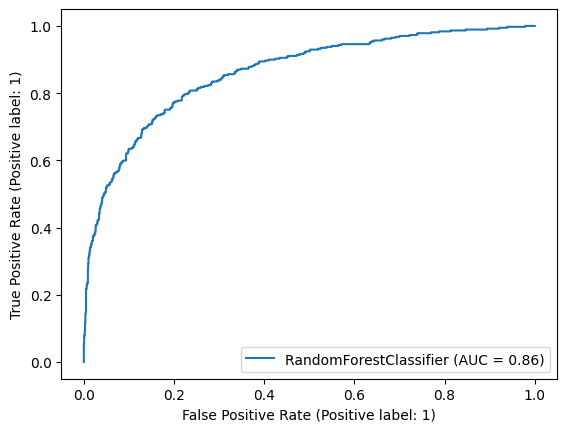

In [29]:
RocCurveDisplay.from_estimator(model, features_test, target_test);

### Вывод
Метрики прогнозирования тестовой выборки  acc 0.81473, roc 0.86168, f1 0.61661, метрики близки к валидационным метрикам

## Шаг 5. Общий вывод


В ходе разработки модели классификации для прогнозирования оттока клиентов  «Бета-Банка» было выполнено: 
1. Открыт, изучен, подготовлен файл с данными.

1.1. Выполнено переименование названия столбцов в змеиный регистр

1.2. Выполнен поиск явных дубликатов - явных дубликатов нет

1.3. Обработаны пропуски в длительностях обслуживания (tenure): 
Преобразован тип данных к целочисленному
в столбце имеются уникальные значения длительностей от 0 до 10 лет, а также 909 занчений NA
В результате просмотра строк с пропущенными значениями возможные причины пропусков не выявлены, пропуски присутсвуют для записей различных клиентов из разных стран, разного пола и т.д.
В результате сравния describe для строк с пропусками и без пропусков установлено, что минимальные, средние, максимальные, std в этих выборках слабо отличаются.
В результате анализа гистограмм для строк с пропусками и без пропусков, не выявлено значительных отличий в распределениях численных признаков.
Доли категориальных значений в этих выборках также примерно равны.
В результате анализа выборок с пропусками и без пропусков в длительности обслуживания, делается предположение о том, что в выборке с пропусками такие же распределения признаков и целевого признака. В связи с этим удаление строк с пропусками не приведет к искажению распределений оставшейся выборки по сравнению с исходной. Произведено удаление строк с пропусками.
В результате анализа гистограмм выявлено, что число клиентов по длительности обслуживания распределено равномерно, кроме нулевого года и 10 года, просадка в нулевом году может быть вызвана выгрузкой базы в середене года. Выброс за 10й год может быть ошибкой. 

1.4. Подготовка признаков
- удалены незначимые признаки ('customer_id','surname')
- закодированы категориальные признаки прямым кодированием
- созданы обучающая, валидационная и тестовая выборки (3:1:1)
- выполнено масштабирование численных признаков
2. Исследован баланс классов, обучена модель без учёта дисбаланса

Доли классов 0 - 0.79, 1 - 0.21

| Model| Accuracy| F1| ROC-AUC|
|:--|:--|:--|:--|
|Решающее дерево| 0.79| 0.49|0.68|
|Случайный лес| 0.86| 0.55|0.83|
|Логистическая регрессия| 0.81| 0.30|0.77|
|Константная модель| 0.80| | |

Качество (accuracy) моделей сопоставимо с константной моделью. Это обусловлено сильным дисбалансом классов целевого признака.

3. Для учета дисбаланса рассмотрены три медота: Взвешивание, Upsampling, downsampling. Максимальные метрики f1 и auc-roc моделей классификации наблюдаются при использовании upsampling для модели случайного леса (f1 = 0.59, AUC-ROC = 0.83). При улучшении данной модели подбором гиперпараметров метрики могут быть увеличены до 0.623 и 0.853 соответственно. Гиперпараметры лучшей модели depth: 9, criterion: gini, n_estimator: 20, min_samples_split: 38.

4. Проверено качество моделей на тестовой выборке. Метрики составили:
| Accuracy| F1| ROC-AUC| полнота| точность|
|:--|:--|:--|:--|:--|
| 0.815| 0.617|0.862|0.734| 0.531|

Метрики близки к значениям валидационных метрик.


Таким образом, обучена модель, позволяющая прогнозировать отток клиентов «Бета-Банка». На тестовой выборке из предсказанных уходов 73% клиентов действительно ушли, 27% остались. Из всех ушедщих клиентов модель предсказала каждого второго (53%), банк может попытаться сохранить этих клиентов. Если банк будет сохранять предсказнных моделью уходящих клиентов, то около четверти расходов (27%) будет избыточна (потрачена на не уходящих клиентов), поэтому стоимость сохранения клиента не должна превышать 73% стоимости привлечения новых клиентов, иначе действия по сохранению нецелесообразны.

